# Setting up the Notebook
---

This notebook aims to introduce the Kato2015 dataset from the paper titled Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans by Kato et al.

We will provide a detailed overview of how the raw data is organized and preprocessed. Although slight modifications may be required for other datasets, the overall methodology remains consistent.

*Last updated: 8th June 2023*

In [1]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from preprocess._utils import interpolate_data, smooth_data_preprocess, reshape_calcium_data
import torch
from tests.leandro.plots import *
from utils import NEURONS_302

ROOT_DIR = '/home/lrvnc/Projects/worm-graph/'
DATA_DIR = os.path.join(ROOT_DIR, 'opensource_data/Kato2015/')
np.random.seed(42)

In [2]:
# Function to print n elements of a list
def print_list(l, n):
    for i in range(n):
        print(l[i])

# Function to pick non-none element from a list
def pick_non_none(l):
    for i in range(len(l)):
        if l[i] is not None:
            return l[i]
        
# Function to determine the similarity between two neurons
def neuron_similarity(neuron1, neuron2):
    neuron1 = neuron1.detach().numpy()
    neuron2 = neuron2.detach().numpy()
    return np.sum(neuron1.T @ neuron2) / (np.linalg.norm(neuron1) * np.linalg.norm(neuron2))


# Raw data structure
---

This dataset is splitted into two matlab documents: WT_Stim.mat and WT_NoStim.mat. Here is how they are sctructured:

* traces_raw= neural activity traces uncorrected
* traces = neural activity traces corrected for bleaching
* tracesDif = derivative of traces
* IDs = identified neuron IDs
* timeVectorSeconds = time vector in seconds
* fps = frames per second
* dataset = name of dataset
* stimulus
	* identity = what was changed e.g. O2 (oxygen)
	* type = stimulus type e.g. binary steps
	* switchtimes =  time in seconds when stimulus changed from initial state to the other state
	* initialstate = the state that the stimulus starts with, refers to "conc"
	* conc = the concentrations of the stimulus
	* concunits - units of the "conc"

States = vector of different state types (8 states for WT_NoStim, 4 states for WT_Stim and AVA_HisCl)

* 8 states for WT_NoStim:
	* ‘FWD’ forward crawling 
	* ‘SLOW’ forward slowing
	* ‘DT’ dorsal post reversal turn
	* ‘VT’ ventral post reversal turn
	* ‘REV1’ reverse crawling
	* ‘REV2’ reverse crawling
	* ‘REVSUS’ sustained reverse crawling
	* ‘NOSTATE’ - ambiguous
  
* 4 states for WT_Stim and AVA_HisCl:
	* ‘FWD’ forward crawling 
	* ‘REV’ reverse crawling
	* ‘REVSUS’ sustained reverse crawling
	* ‘TURN’ post reversal turn

# Processing the data
---

In [3]:
# Loading the data
dataset_raw = mat73.loadmat(DATA_DIR+'WT_Stim.mat')["WT_Stim"] # Return a dict
print('Raw data keys:', dataset_raw.keys(), end='\n\n')

# We will use just these features
features = ['IDs', 'traces', 'timeVectorSeconds']
sizes = {}
for ft in features:
    sizes[ft] = [len(data) for data in dataset_raw[ft]]
print('The features have the following sizes:')
for ft in features:
    print(' {}: {}'.format(ft, sizes[ft]))

Raw data keys: dict_keys(['IDs', 'States', 'dataset', 'fps', 'stimulus', 'timeVectorSeconds', 'traces', 'tracesDif', 'traces_raw'])

The features have the following sizes:
 IDs: [107, 122, 124, 134, 123, 151, 146]
 traces: [2198, 2017, 2197, 2018, 2201, 2017, 2019]
 timeVectorSeconds: [2198, 2017, 2197, 2018, 2201, 2017, 2019]


## Extracting neuron IDs
---

In [4]:
# Let's take a look at the IDs
print_list(dataset_raw['IDs'], 2)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, ['IL1DR', 'URYDR'], None, None, None, None, ['IL1DL', 'URYDL'], ['OLQDR', 'URYDR'], ['OLQVR', 'URYVR'], ['OLQVL', 'URYVL'], ['OLQDL', 'URYDL'], None, None, ['BAGL'], ['BAGR'], ['RMED'], ['RMEL'], None, None, ['RID'], None, None, ['RMEV'], ['ASKR'], [None, 'AFDL', 'ASKL'], ['AVAL'], None, ['ASKL', 'AFDL'], ['URXL', 'URXR'], ['ALA'], None, None, None, None, ['AVEL'], None, None, None, None, None, None, None, ['RIVL', 'AVHL', 'AVJL'], ['AIBR'], None, ['AVBL'], ['AIBL'], None, ['RIMR'], None, None, None, ['RIBL'], None, None, ['RIBR'], None, ['SMBDR', None], ['RIML'], None, None, None, None, None, None, None, None, None, None, None, ['RIS'], ['VB02'], None, ['AVFR'], ['SABVL', 'SABVR'], ['AVFL'], ['SABVR', None], ['RIFR'], None, ['VB01'], None, [None, 'RIGR'], ['SABD'], ['VA01'], ['RIGL'], None, ['SMDVL'], None, ['AVAR'], ['AVBR'], ['DB01'], ['DB02']]
[None, None, None, None, None, None, None, 

In [5]:
# Each list represents a worm. We need to extract just the neurons that are actives.
# Here we exemplify for the 5th worm.

oneID = dataset_raw['IDs'][4]
print('Raw IDs ({}): {}'.format(len(oneID), oneID))
oneID = [(pick_non_none(j) if isinstance(j, list) else j) for j in oneID] # Just the first active neuron
oneID = [
            (str(_) if j is None or isinstance(j, np.ndarray) else str(j))
            for _, j in enumerate(oneID)
        ] # Position on the list or name of the neuron
print('None to position ({}): {}'.format(len(oneID), oneID))
_, inds = np.unique(
            oneID, return_index=True
        )  # Get unique neurons and their indices
oneID = [oneID[i] for i in inds] # Get unique neurons
print('Unique neurons ({}): {}'.format(len(oneID), oneID))

Raw IDs (123): [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, ['URYDR'], ['URYVL'], ['URYVR'], ['URADL'], ['URADR'], ['URYDL'], None, None, None, ['BAGL'], ['OLQVR'], None, None, ['OLQDL', 'URYDL'], ['OLQVL', 'URYVL'], ['OLQDR', 'URYDR'], ['BAGR'], ['RMER'], ['RMEL'], ['RMED'], None, ['RMEV'], None, None, ['RID'], None, ['AVAL'], None, ['---'], ['RMDVL'], ['---'], ['---', '---'], ['AVAR'], ['SMDVR'], ['ALA'], ['AVEL'], None, None, None, None, ['AVER'], ['URXL', 'URXR'], None, None, None, None, None, None, None, None, ['AIBL'], ['AIBR'], None, None, ['RIBL'], None, None, None, None, ['SIADR', None, '---'], None, ['AVBR'], ['AVBL'], None, None, ['RIBR'], None, None, None, None, None, ['RIMR'], ['RIVR', '---', '---'], None, None, None, None, None, ['RIML'], ['SMBDL'], None, None, None, ['SMBDR'], None, None, None, None, None, None, None, None, None, None, None, None, ['RIS'], None, None, ['VB02'], ['AVFR'], ['SABVR', 'SABVL'], ['AVFL

After extracting the labels, we obtain a list that contains the indexes of the neurons. In cases where a neuron couldn't be identified, it is assigned a numerical value. To obtain a list of unique labels, we can utilize the numpy unique function. This function allows us to filter out any repeated labels, providing us with a concise and distinct set of identified neurons for further analysis.

# Extracting the Traces
---

By utilizing the ordering of the unique neuron labels obtained from the numpy unique function, we can reorganize the columns of the calcium data. This reorganization ensures that the columns align with the specific neurons they represent, facilitating data analysis and interpretation.

In [6]:
# Using just the unique neurons, we can extract the traces
oneTrace = dataset_raw['traces'][4]
oneTrace = oneTrace[:, inds] # reordering columns
print('Unique traces: {}'.format(oneTrace.shape))

Unique traces: (2201, 121)


# Mapping the neurons
---

In [7]:
# Here is how we map the neurons to indices
neuron_to_idx = {
            nid: (str(nid) if (j is None or isinstance(j, np.ndarray)) else str(j))
            for nid, j in enumerate(oneID)
        }

print(neuron_to_idx)

{0: '---', 1: '0', 2: '1', 3: '10', 4: '101', 5: '102', 6: '103', 7: '104', 8: '105', 9: '106', 10: '107', 11: '108', 12: '109', 13: '11', 14: '110', 15: '111', 16: '112', 17: '114', 18: '115', 19: '12', 20: '13', 21: '14', 22: '15', 23: '16', 24: '2', 25: '23', 26: '24', 27: '25', 28: '28', 29: '29', 30: '3', 31: '37', 32: '39', 33: '4', 34: '40', 35: '42', 36: '44', 37: '5', 38: '53', 39: '54', 40: '55', 41: '56', 42: '59', 43: '6', 44: '60', 45: '61', 46: '62', 47: '63', 48: '64', 49: '65', 50: '66', 51: '69', 52: '7', 53: '70', 54: '72', 55: '73', 56: '74', 57: '75', 58: '77', 59: '8', 60: '80', 61: '81', 62: '83', 63: '84', 64: '85', 65: '86', 66: '87', 67: '9', 68: '90', 69: '91', 70: '92', 71: '93', 72: '94', 73: '97', 74: '98', 75: '99', 76: 'AIBL', 77: 'AIBR', 78: 'ALA', 79: 'AVAL', 80: 'AVAR', 81: 'AVBL', 82: 'AVBR', 83: 'AVEL', 84: 'AVER', 85: 'AVFL', 86: 'AVFR', 87: 'BAGL', 88: 'BAGR', 89: 'DB02', 90: 'OLQDL', 91: 'OLQDR', 92: 'OLQVL', 93: 'OLQVR', 94: 'RIBL', 95: 'RIBR', 9

In [8]:
# Format the neuron names if it finishes with 0
neuron_to_idx = {
            nid: (
                name.replace("0", "")
                if not name.endswith("0") and not name.isnumeric()
                else name
            )
            for nid, name in neuron_to_idx.items()
        }
print(neuron_to_idx)

{0: '---', 1: '0', 2: '1', 3: '10', 4: '101', 5: '102', 6: '103', 7: '104', 8: '105', 9: '106', 10: '107', 11: '108', 12: '109', 13: '11', 14: '110', 15: '111', 16: '112', 17: '114', 18: '115', 19: '12', 20: '13', 21: '14', 22: '15', 23: '16', 24: '2', 25: '23', 26: '24', 27: '25', 28: '28', 29: '29', 30: '3', 31: '37', 32: '39', 33: '4', 34: '40', 35: '42', 36: '44', 37: '5', 38: '53', 39: '54', 40: '55', 41: '56', 42: '59', 43: '6', 44: '60', 45: '61', 46: '62', 47: '63', 48: '64', 49: '65', 50: '66', 51: '69', 52: '7', 53: '70', 54: '72', 55: '73', 56: '74', 57: '75', 58: '77', 59: '8', 60: '80', 61: '81', 62: '83', 63: '84', 64: '85', 65: '86', 66: '87', 67: '9', 68: '90', 69: '91', 70: '92', 71: '93', 72: '94', 73: '97', 74: '98', 75: '99', 76: 'AIBL', 77: 'AIBR', 78: 'ALA', 79: 'AVAL', 80: 'AVAR', 81: 'AVBL', 82: 'AVBR', 83: 'AVEL', 84: 'AVER', 85: 'AVFL', 86: 'AVFR', 87: 'BAGL', 88: 'BAGR', 89: 'DB2', 90: 'OLQDL', 91: 'OLQDR', 92: 'OLQVL', 93: 'OLQVR', 94: 'RIBL', 95: 'RIBR', 96

In [9]:
# Standardize the neuron ordering
neuron_to_idx = {
    nid: (str(nid) if name not in set(NEURONS_302) else name)
    for nid, name in neuron_to_idx.items()
}
print(neuron_to_idx)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 41: '41', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48', 49: '49', 50: '50', 51: '51', 52: '52', 53: '53', 54: '54', 55: '55', 56: '56', 57: '57', 58: '58', 59: '59', 60: '60', 61: '61', 62: '62', 63: '63', 64: '64', 65: '65', 66: '66', 67: '67', 68: '68', 69: '69', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: 'AIBL', 77: 'AIBR', 78: 'ALA', 79: 'AVAL', 80: 'AVAR', 81: 'AVBL', 82: 'AVBR', 83: 'AVEL', 84: 'AVER', 85: 'AVFL', 86: 'AVFR', 87: 'BAGL', 88: 'BAGR', 89: 'DB2', 90: 'OLQDL', 91: 'OLQDR', 92: 'OLQVL', 93: 'OLQVR', 94: 'RIBL', 95: 'RIBR', 96: 'RID', 97: 'R

In [10]:
# Invert the mapping
neuron_to_idx = dict((v, k) for k, v in neuron_to_idx.items())
print(neuron_to_idx)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50, '51': 51, '52': 52, '53': 53, '54': 54, '55': 55, '56': 56, '57': 57, '58': 58, '59': 59, '60': 60, '61': 61, '62': 62, '63': 63, '64': 64, '65': 65, '66': 66, '67': 67, '68': 68, '69': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, 'AIBL': 76, 'AIBR': 77, 'ALA': 78, 'AVAL': 79, 'AVAR': 80, 'AVBL': 81, 'AVBR': 82, 'AVEL': 83, 'AVER': 84, 'AVFL': 85, 'AVFR': 86, 'BAGL': 87, 'BAGR': 88, 'DB2': 89, 'OLQDL': 90, 'OLQDR': 91, 'OLQVL': 92, 'OLQVR': 93, 'RIBL': 94, 'RIBR': 95, 'RID': 96, 'RIGR'

In [11]:
num_named_neurons = len(
            [k for k in neuron_to_idx.keys() if not k.isnumeric()]
        )  # number of neurons that were labeled with a name
print('Number of named neurons:', num_named_neurons)

Number of named neurons: 45


# Extracting time vector
---

In [12]:
# Reshape it to a column vector
oneTime = dataset_raw['timeVectorSeconds'][4]
oneTime = oneTime.reshape(-1, 1)
print('Time vector: {}'.format(oneTime.shape))

Time vector: (2201, 1)


# Transforming data
---

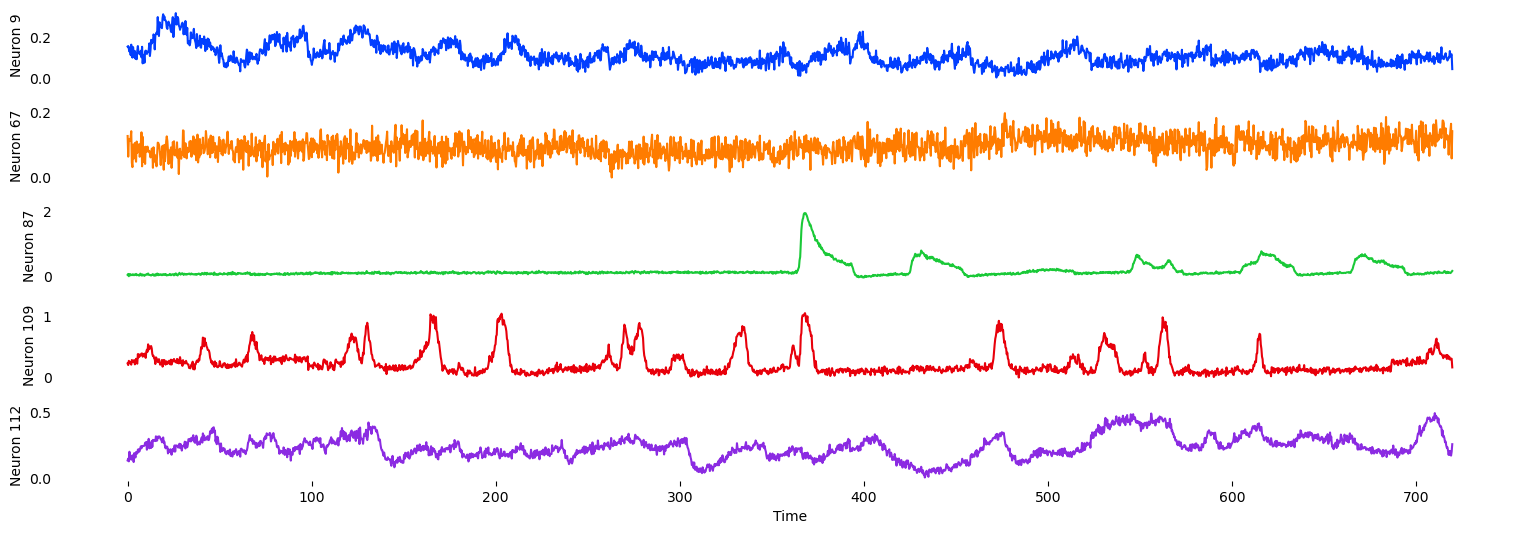

In [13]:
# Let's plot the raw traces
plot_signals(torch.from_numpy(oneTrace), torch.from_numpy(oneTime), [9, 67, 87, 109, 112], yax_limit=False)

In [14]:
# We can choose to normalize the traces in the time dimension or in the feature dimension
transform = StandardScaler()
oneTrace_norm_ft = transform.fit_transform(oneTrace) # Normalize in the feature dimension

In [15]:
oneTime = torch.from_numpy(oneTime).float()
oneTrace = torch.from_numpy(oneTrace_norm_ft).float()

# Resampling and Smoothing the data
---

In [16]:
# We create a vector containing the time steps
dt = np.gradient(oneTime, axis=0)
dt[dt == 0] = np.finfo(float).eps # assigning a very small positive value to any element equal to zero.

In [17]:
# Calculating the residual calcium (derivative of the calcium in time)
residual_calcium = np.gradient(oneTrace, axis=0) / dt

Time step difference: [0.1 0.1 0.1 ... 0.1 0.1 0.1]


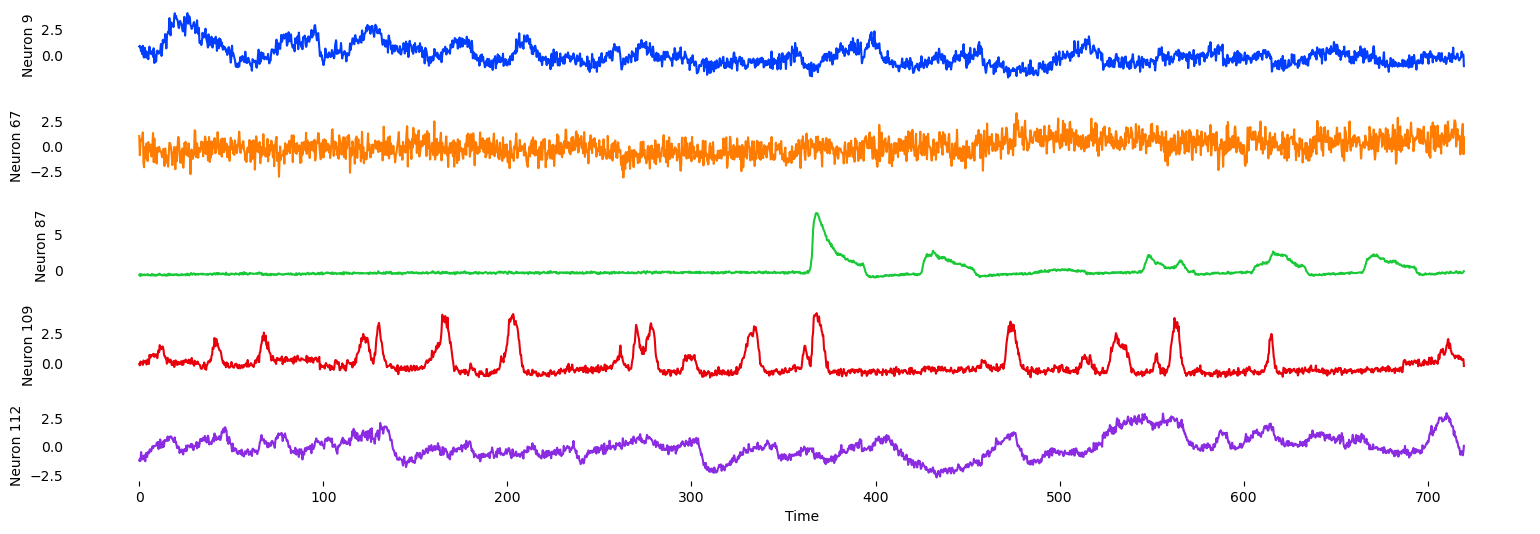

Time vector: (7197,)
Unique traces: (7197, 121)


In [18]:
# We resample the signal to a fixed time step
oneTime_interp, oneTrace_interp = interpolate_data(oneTime, oneTrace, target_dt=0.1)

# Print difference between consecutive time steps of interpolated oneTime
print('Time step difference: {}'.format(np.diff(oneTime_interp.flatten())))

# Let's plot the resampled traces
plot_signals(torch.from_numpy(oneTrace_interp), torch.from_numpy(oneTime_interp), [9, 67, 87, 109, 112], yax_limit=False)

print('Time vector: {}'.format(oneTime_interp.shape))
print('Unique traces: {}'.format(oneTrace_interp.shape))

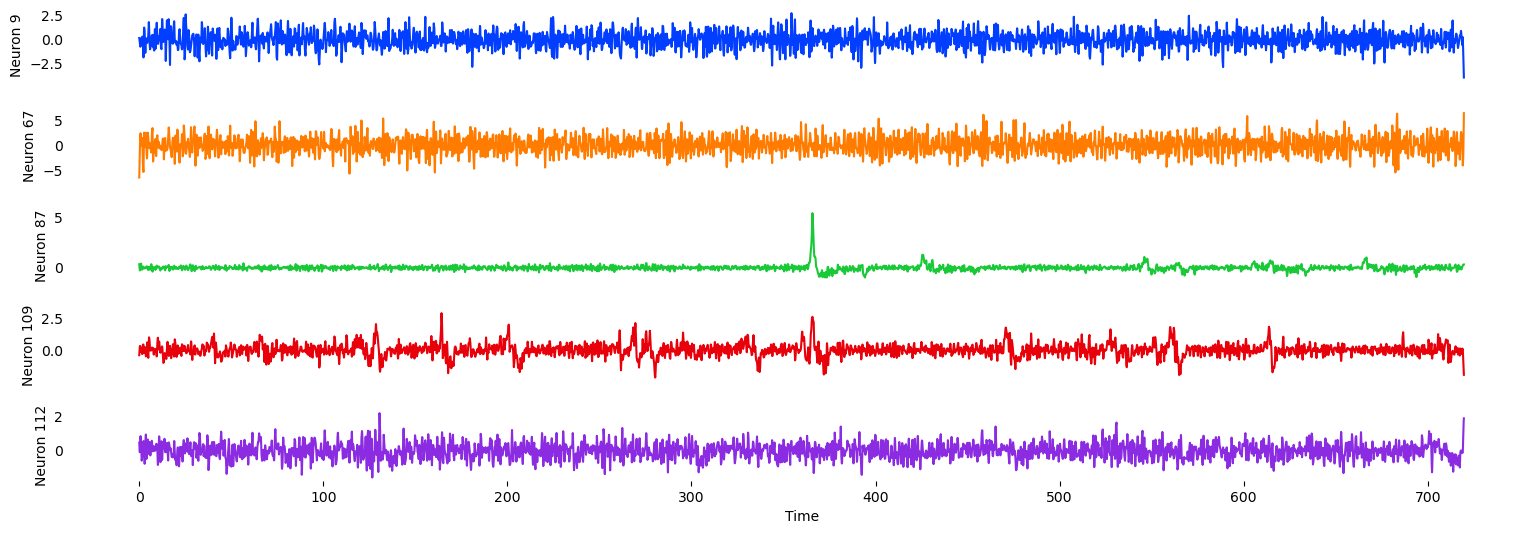

Resampled residual calcium shape: (7197, 121)


In [19]:
# Resample the residual calcium
_, residual_calcium_interp = interpolate_data(oneTime, residual_calcium, target_dt=0.1)
plot_signals(torch.from_numpy(residual_calcium_interp), torch.from_numpy(oneTime_interp), [9, 67, 87, 109, 112], yax_limit=False)
print('Resampled residual calcium shape: {}'.format(residual_calcium_interp.shape))

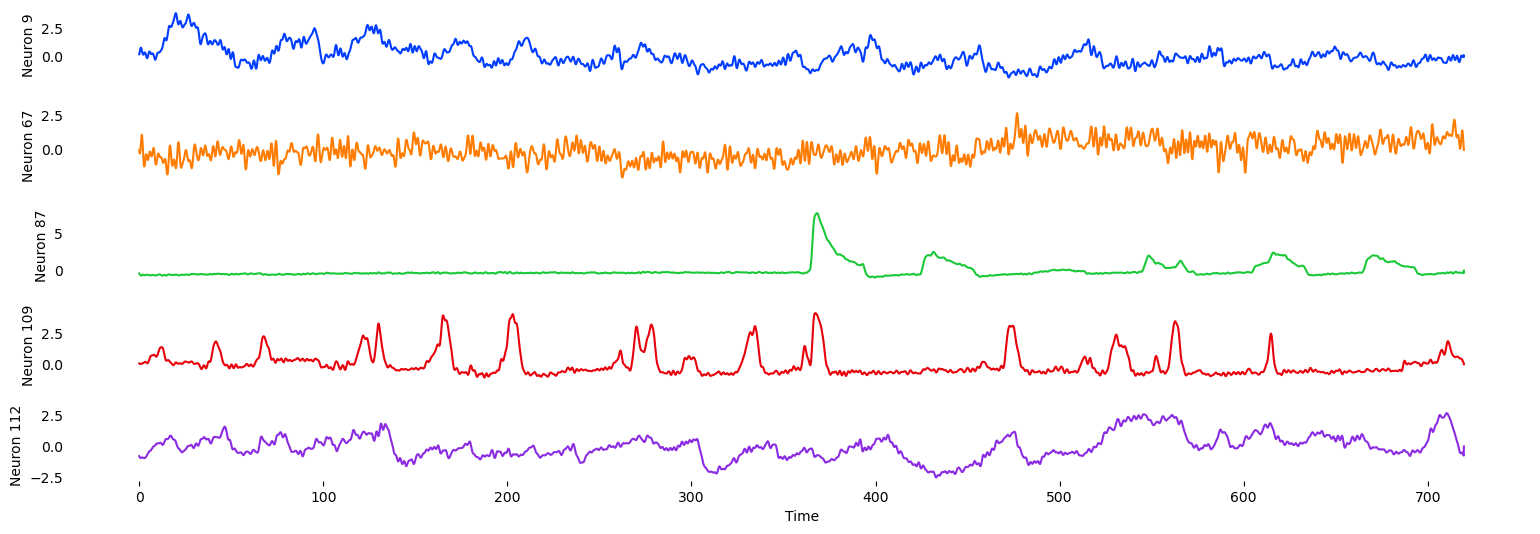

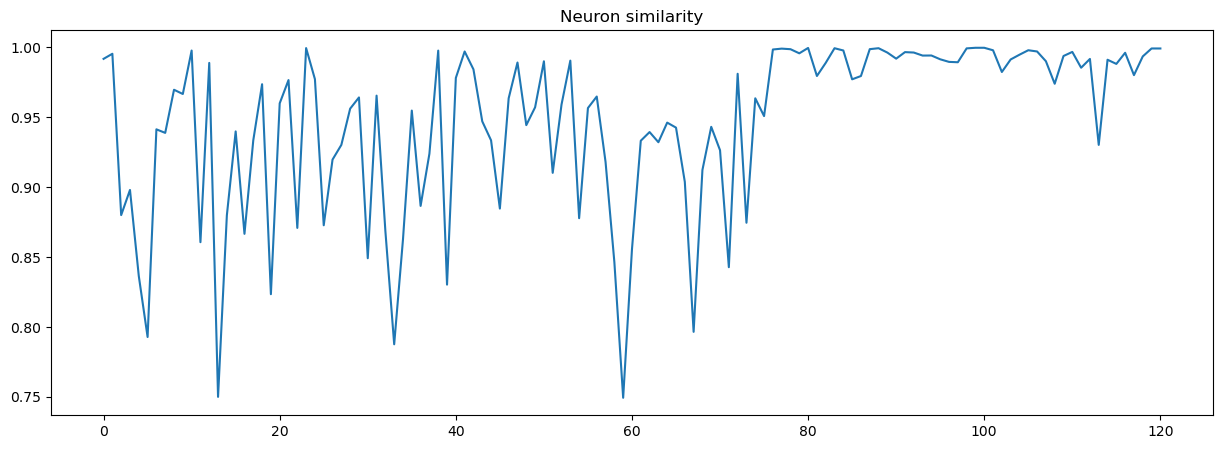

In [20]:
# Now, we smooth the data using the FFT method
oneTrace_smooth = smooth_data_preprocess(oneTrace_interp, time_in_seconds=oneTime_interp, smooth_method='fft')

# Let's plot the smoothed traces
plot_signals(torch.from_numpy(oneTrace_smooth), torch.from_numpy(oneTime_interp), [9, 67, 87, 109, 112], yax_limit=False)

# Let's see the similarity between the neurons (columns)
sim = []
for n in range(oneTrace_smooth.shape[1]):
    sim.append(neuron_similarity(torch.from_numpy(oneTrace_smooth[:, n]), torch.from_numpy(oneTrace_interp[:, n])))

plt.figure(figsize=(15, 5))
plt.plot(sim)
plt.title('Neuron similarity')
plt.show()

In [21]:
# Same for the residual calcium
residual_calcium_smooth = smooth_data_preprocess(residual_calcium_interp, time_in_seconds=oneTime_interp, smooth_method='fft')

# Saving the data
---

In [22]:
# Finally we need to reshape the data to a standard format
# First we save all the data inside a data dict to pass to the function

oneDict = {}

oneDict.update(
    {
        "worm0": {
            "dataset": "Kato2015",
            "smooth_method": "FFT",
            "worm": "worm0",
            "calcium_data": oneTrace_interp,
            "smooth_calcium_data": oneTrace_smooth,
            "residual_calcium": residual_calcium_interp,
            "smooth_residual_calcium": residual_calcium_smooth,
            "neuron_to_idx": neuron_to_idx,
            "idx_to_neuron": dict((v, k) for k, v in neuron_to_idx.items()),
            "max_timesteps": oneTrace_interp.shape[0],
            "time_in_seconds": oneTime_interp,
            "dt": .10,
            "num_neurons": oneTrace_interp.shape[1], # labeled + unlabeled
            "num_named_neurons": num_named_neurons, # labeled
            "num_unknown_neurons": oneTrace_interp.shape[1] - num_named_neurons, # unlabeled
        },
    }
)

In [23]:
# Now we can call the function to reshape the data  to a standard format
oneDict_std = reshape_calcium_data(oneDict['worm0'])

# Here are the keys of the final dict
print(oneDict_std.keys())

dict_keys(['dataset', 'smooth_method', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', 'max_timesteps', 'time_in_seconds', 'dt', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons', 'named_neurons_mask', 'unknown_neurons_mask', 'neurons_mask', 'slot_to_named_neuron', 'named_neuron_to_slot', 'slot_to_unknown_neuron', 'unknown_neuron_to_slot', 'slot_to_neuron', 'neuron_to_slot'])


In [24]:
for key in oneDict_std.keys():
    if type(oneDict_std[key]) is str:
        print('{}: {}'.format(key, oneDict_std[key]))
    elif (type(oneDict_std[key]) is float) or (type(oneDict_std[key]) is int):
        print('{}: {}'.format(key, oneDict_std[key]))
    elif (type(oneDict_std[key]) is dict):
        print('{}: {}'.format(key, len(oneDict_std[key])))
    else:
        print('{}: {}'.format(key, oneDict_std[key].shape))

dataset: Kato2015
smooth_method: FFT
worm: worm0
calcium_data: torch.Size([7197, 302])
smooth_calcium_data: torch.Size([7197, 302])
residual_calcium: torch.Size([7197, 302])
smooth_residual_calcium: torch.Size([7197, 302])
max_timesteps: 7197
time_in_seconds: torch.Size([7197, 1])
dt: torch.Size([7197, 1])
num_neurons: 121
num_named_neurons: 45
num_unknown_neurons: 76
named_neurons_mask: torch.Size([302])
unknown_neurons_mask: torch.Size([302])
neurons_mask: torch.Size([302])
slot_to_named_neuron: 45
named_neuron_to_slot: 45
slot_to_unknown_neuron: 76
unknown_neuron_to_slot: 76
slot_to_neuron: 121
neuron_to_slot: 121


Now that the data is ready for use! Here is a description of each element within the dataset:

* `dataset`: (str) Name of the dataset
* `smooth_method`: (str) Method used to smooth the calcium data
* `worm`: (str) The worm ID in the dataset
* `max_timesteps`: (float) Number of time steps of the data
* `dt`: (float) Difference between time steps
* `calcium_data`: (torch.tensor) The calcium data, with standardized columns. Shape: (max_timesteps, 302)
* `smooth_calcium_data`: (torch.tensor) Smoothed calcium data, with standardized columns. Shape: (max_timesteps, 302)
* `residual_calcium`: (torch.tensor) The residual calcium data, with standardized columns. Shape: (max_timesteps, 302)
* `smooth_residual_calcium`: (torch.tensor) Smoothed residual calcium data, with standardized columns. Shape: (max_timesteps, 302)
* `time_in_seconds`: (torch.tensor) A column vector equally spaced by `dt`. Shape: (`max_timesteps`, 1)
* `num_neurons`: (int) Number of total tracked neurons of this specific worm
* `num_named_neurons`: (int) Number of labeled neurons
* `num_unknown_neurons`: (int) Number of unlabeled neurons
* `named_neurons_mask`: (torch.tensor) A bool vector indicating the positions of the labeled neurons. Shape: (302)
* `unknown_neurons_mask`: (torch.tensor) A bool vector indicating the positions of the unlabeled neurons. Shape: (302)
* `neurons_mask`: (torch.tensor) A bool vector indication the positions of all tracked neurons (labeled + unlabeled). Shape: (302)
* `slot_to_named_neuron`: (dict) Mapping of column index -> 302 neurons. Len: `num_neurons`
* `named_neuron_to_slot`: (dict) Mapping of 302 neurons -> column index. Len: `num_neurons`
* `slot_to_unknown_neuron`: (dict) Mapping of column index -> unlabeled neuron. Len: `num_unknown_neurons`
* `unknown_neuron_to_slot`: (dict) Mapping of unlabeled neurons -> column index. Len: `num_unknown_neurons`
* `slot_to_neuron`: (dict) Mapping of column intex -> labeled+unlabeled neurons. Len: `num_neurons`
* `neuron_to_slot`: (dict) Mapping of labeled+unlabeled neurons -> column index. Len: `num_neurons`